In [37]:
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
import warnings
warnings.filterwarnings('ignore')

#### Read and load a new modified dataset

In [39]:
users = pd.read_parquet("./data/users.parquet")
users.head()

,user_id,time_night_owl,time_early_morning_browser,time_midday_browser,time_late_day_browser,app_category_Browsing,app_category_Entertainment,app_category_Money,app_category_Social,app_category_Utility,number_of_apps,number_of_sessions,avg_session_length
0,0,1,0,0,1,0,1,0,0,0,19,238,0.658333
1,1,0,0,0,1,0,0,0,1,0,18,88,1.483333
2,2,0,1,0,0,0,0,0,1,0,16,61,0.533333
3,3,0,0,0,1,0,0,1,0,0,15,70,0.116667
4,4,1,0,0,0,0,0,0,1,0,8,45,0.233333


#### Tansform variables (continuous columns) to be the same scale (important before apply clustring)

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = users.drop(columns=["user_id"])  # drop user_id column for clustering

continuous_features = ['number_of_apps', 'number_of_sessions', 'avg_session_length']

X_scaled = X.copy()

X_scaled.loc[:, continuous_features]  = scaler.fit_transform(X[continuous_features])  # transform only continuous columns and overwrite their values

X_scaled.head().transpose()

,0,1,2,3,4
time_night_owl,1.000000,0.000000,0.000000,0.000000,1.000000
time_early_morning_browser,0.000000,0.000000,1.000000,0.000000,0.000000
time_midday_browser,0.000000,0.000000,0.000000,0.000000,0.000000
time_late_day_browser,1.000000,1.000000,0.000000,1.000000,0.000000
app_category_Browsing,0.000000,0.000000,0.000000,0.000000,0.000000
app_category_Entertainment,1.000000,0.000000,0.000000,0.000000,0.000000
app_category_Money,0.000000,0.000000,0.000000,1.000000,0.000000
app_category_Social,0.000000,1.000000,1.000000,0.000000,1.000000
app_category_Utility,0.000000,0.000000,0.000000,0.000000,0.000000
number_of_apps,0.442882,0.286854,-0.025200,-0.181228,-1.273419


#### Apply KMeans algorithm from 3 groups (clusters) up to 15 and plot 'inertia' scores

In [41]:
from sklearn.cluster import KMeans

k_values = range(3, 15)
inertia_values = []

for k in k_values:
    # calculte inertia for each cluster
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

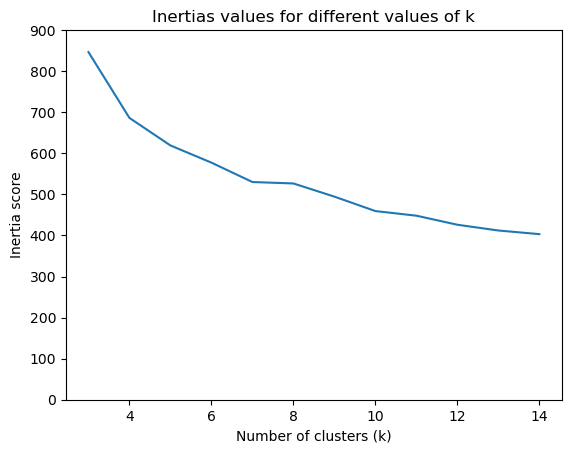

In [42]:
fig, axis = plt.subplots()

axis.plot(k_values, inertia_values)

_ = axis.set(
    title = "Inertias values for different values of k",
    xlabel = "Number of clusters (k)",
    ylabel= "Inertia score"
)

axis.set_ybound(0, 900)
plt.savefig('inertia_score_per_cluster')
plt.show()

In [43]:
kmeans = KMeans(n_clusters=7, random_state=42)  # choose k=7 (number of clusters)
clusters = kmeans.fit_predict(X_scaled)
users["cluster"] = clusters  # add a new column 'cluster' for each user

users.head().transpose()  

,0,1,2,3,4
user_id,0.000000,1.000000,2.000000,3.000000,4.000000
time_night_owl,1.000000,0.000000,0.000000,0.000000,1.000000
time_early_morning_browser,0.000000,0.000000,1.000000,0.000000,0.000000
time_midday_browser,0.000000,0.000000,0.000000,0.000000,0.000000
time_late_day_browser,1.000000,1.000000,0.000000,1.000000,0.000000
app_category_Browsing,0.000000,0.000000,0.000000,0.000000,0.000000
app_category_Entertainment,1.000000,0.000000,0.000000,0.000000,0.000000
app_category_Money,0.000000,0.000000,0.000000,1.000000,0.000000
app_category_Social,0.000000,1.000000,1.000000,0.000000,1.000000
app_category_Utility,0.000000,0.000000,0.000000,0.000000,0.000000


#### How many users are in each cluster?

In [44]:
users["cluster"].value_counts().sort_index()

cluster
0    42
1    31
2    60
3    78
4     3
5     2
6    75
Name: count, dtype: int64

#### Look at the clusters’ centers

In [45]:
import numpy as np

original_cluster_centers  = np.copy(kmeans.cluster_centers_)  # make a copy of cluster centers.

cluster_centers = pd.DataFrame(
    data=original_cluster_centers,
    columns=X_scaled.columns
    )

cluster_centers.loc[:,continuous_features] = scaler.inverse_transform(original_cluster_centers[:,-3:])  # reverse the transformation for the continuous columns

cluster_centers.transpose().round(2)

,0,1,2,3,4,5,6
time_night_owl,0.48,0.45,0.33,1.00,0.00,0.00,0.00
time_early_morning_browser,0.24,0.06,0.17,0.05,0.00,0.00,0.19
time_midday_browser,0.17,0.03,0.32,0.04,0.67,0.00,0.36
time_late_day_browser,0.36,0.48,0.53,0.22,0.33,1.00,0.60
app_category_Browsing,0.10,0.00,0.43,0.05,0.00,0.00,0.05
app_category_Entertainment,0.05,-0.00,0.13,0.05,0.00,0.00,0.03
app_category_Money,0.05,0.00,-0.00,0.05,0.00,0.00,0.08
app_category_Social,0.76,0.97,0.28,0.79,1.00,1.00,0.83
app_category_Utility,0.05,0.03,0.15,0.05,0.00,0.00,0.01
number_of_apps,15.64,24.35,7.18,18.18,27.33,19.50,17.61


-
It looks like groups 4 and 5 are the outlier groups in terms of number of sessions and average session length respectivel <br>                       -Group 1 are heavy users, mostly for social media and late in the day or at nigh-htours".